In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/

Mounted at /content/drive
/content/drive/MyDrive/Github


In [5]:
!git clone https://<<your_github_token>>@github.com/<<your_github_username>>/questions-with-SQL

Cloning into 'questions-with-SQL'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (29/29), 724.79 KiB | 5.89 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [7]:
%cd questions-with-SQL

/content/drive/MyDrive/Github/questions-with-SQL


# Answering Business Questions Using SQL

In this guided project by Dataquest (DQ), I used SQL to answer business questions using information about a fictional digital music shop. The Chinook database contains information about the artists, songs, and albums from the music shop, as well as data on the shop's employees, customers, and the customers' purchases.

The goal is to find answers and provide recommendations on the following:

* Which music genres sell the most tracks in the USA?
* What is the sales performance of the shop's employees?
* Which countries have the potential for growth?
* What percentage of purchases are whole albums versus individual tracks?
* Which artist is used in most playlists?
* How many tracks have been purchased versus not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected versus non-protected media types affect sales popularity?

## Creating Helper Functions

Use the helper functions

`run_query()` to quickly read SQL queries into DataFrames


`show_tables()` to return a list of all tables and views of the Chinook database, respectively.

In [8]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def show_tables():
    q = '''
    SELECT
        name

    FROM sqlite_master
    WHERE type in ("table", "view");
    '''
    return run_query(q)

show_tables()

,name
0,album
1,artist
2,customer
3,employee
4,genre
5,invoice
6,invoice_line
7,media_type
8,playlist
9,playlist_track


The Chinook database contains 11 tables of data.  The tables are related according to the database schema shown below.

![Chinook Schema](https://github.com/orcascope/questions-with-SQL/blob/master/chinook-schema.jpg?raw=1)

1. Top 3 customer states in terms of  invoice total
2. Get just the Top 5th (not top 5) customer state in terms of number of distinct customers.
3. Find the top Selling Music Genres in the USA

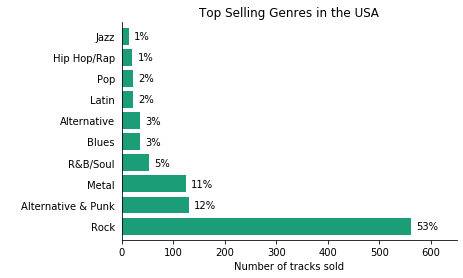

In [ ]:
q1 = '''

WITH
    usa_genre_tracks AS
    (
    SELECT
        g.name Genre,
        COUNT(g.name) Tracks_sold
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    WHERE c.country = "USA"
    GROUP BY 1
    ORDER BY 2 DESC
    )

SELECT
    ugt.*,
    ROUND((CAST(ugt.Tracks_sold as FLOAT) / (
                                            SELECT SUM(ugt.Tracks_sold)
                                            FROM usa_genre_tracks ugt)
                                            )*100, 2) Percent_sold
FROM usa_genre_tracks ugt
'''

usa_genre_tracks = run_query(q1)

ax = usa_genre_tracks[0:10].plot.barh(
    title='Top Selling Genres in the USA',
    xlim=(0, 650),
    x='Genre',
    y='Tracks_sold',
    legend=False,
    width=0.8,
    colormap=cm.Dark2
)

ax.set_ylabel(' ')
ax.set_xlabel('Number of tracks sold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=False)

for count in range(10):
    x_coor = usa_genre_tracks['Tracks_sold'][count]
    text = usa_genre_tracks['Percent_sold'][count].astype(int).astype(str) + '%'
    ax.annotate(s=text, xy=(x_coor+10,count-0.15))

plt.savefig('top_genres.jpg')
plt.show()

Based on the number of tracks sold across different genres in the USA, `Rock` is the top selling genre, followed by `Alternative & Punk`, `Metal`, and `R&B/Soul`. With knowlege of the top-selling genres, new albums by American artists from a record label can be added to the music shop.

## Analyzing Employee Sales Performance

  Sales_support_agent            hire_date country  Total_sales_$
0        Jane Peacock  2017-04-01 00:00:00  Canada        1731.51
1       Margaret Park  2017-05-03 00:00:00  Canada        1584.00
2       Steve Johnson  2017-10-17 00:00:00  Canada        1393.92


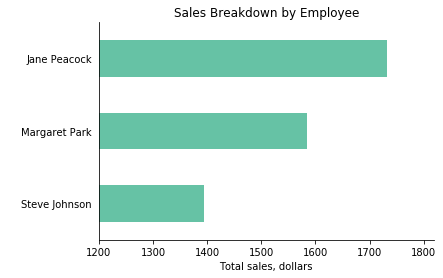

In [ ]:
q2 = '''

SELECT
    e.first_name || " " || e.last_name Sales_support_agent,
    e.hire_date,
    e.country,
    SUM(i.total) Total_sales_$
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
'''

employee_sales = run_query(q2)
print(employee_sales)
employee_sales.sort_values(by='Total_sales_$', inplace=True)
ax = employee_sales.plot.barh(
                            x='Sales_support_agent',
                            y='Total_sales_$',
                            legend=False,
                            title='Sales Breakdown by Employee',
                            colormap=plt.cm.Set2
                            )
ax.set_ylabel(' ')
ax.set_xlabel('Total sales, dollars')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=False)
ax.set_xlim(left=1200)
plt.show()


In terms of total dollar sales, Jane Peacock is the top employee. The difference in sales between employees corresponds with the difference in their hiring dates.

## Analyzing Sales by Country

In [ ]:
q3 = '''

WITH country_sales AS
    (
    SELECT
        CASE
            WHEN (
                 SELECT COUNT(DISTINCT c.customer_id)
                 FROM customer
                 WHERE country = c.country
                 ) = 1 THEN "Other"
            ELSE c.country
            END
        AS Country,
        COUNT(DISTINCT c.customer_id) Customers,
        COUNT(DISTINCT i.invoice_id) Invoices,
        TOTAL(i.total) Total_sales
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY Country
    )

SELECT
    Country,
    SUM(Customers) Customers,
    TOTAL(Total_sales) Total_sales,
    ROUND(TOTAL(Total_sales) / SUM(Customers), 2) Average_value_of_sales,
    ROUND(TOTAL(Total_sales) / SUM(Invoices), 2) Average_order_value
FROM
    (
    SELECT
        cs.*,
        CASE
            WHEN cs.Country = "Other" THEN 1
            ELSE 0
            END
        AS sort
    FROM country_sales cs
    )
GROUP BY 1
ORDER BY sort ASC, 3 DESC

'''

run_query(q3)

,Country,Customers,Total_sales,Average_value_of_sales,Average_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.58,8.72
9,Other,15,1094.94,73.00,7.45


Results of the data analysis show USA has the most number of customers and amount of sales. Meanwhile, Czech Republic has the highest average value of sales (dollar per customer) and average order value (dollar per invoice).  

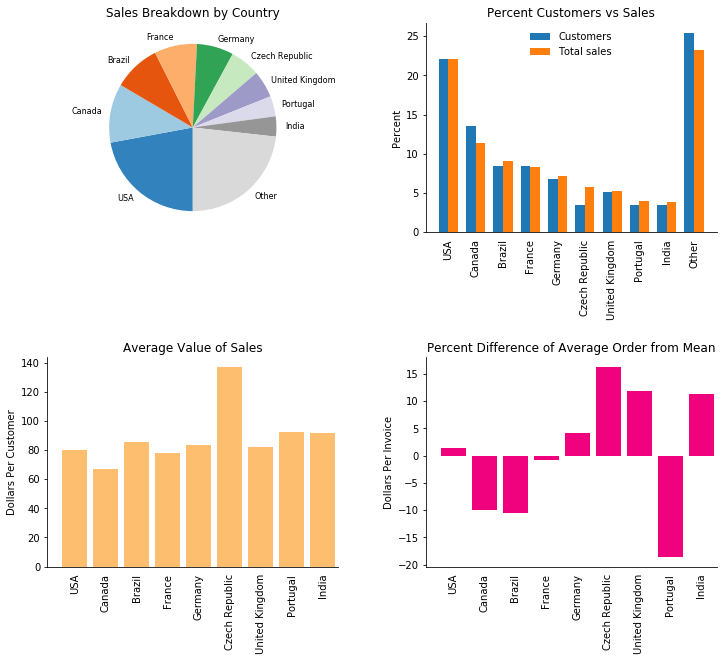

In [ ]:
df = run_query(q3)

fig, axs = plt.subplots(2,2, figsize=(12, 10))
fig.subplots_adjust(hspace=.6, wspace=.3)

# Sales Breakdown by Country
axs[0,0].pie(
    df['Total_sales'],
    labels=df['Country'],
    startangle=-90,
    counterclock=False,
    textprops={'size': 8},
    wedgeprops={'linewidth':0},
    colors=cm.tab20c(np.linspace(0,1,10))
)
axs[0,0].set_title('Sales Breakdown by Country')


# Percent Customers vs Sales
df_cust_sales = df[['Customers', 'Total_sales']].copy()
df_cust_sales['Customers'] /= df_cust_sales['Customers'].sum()/100
df_cust_sales['Total_sales'] /= df_cust_sales['Total_sales'].sum()/100
x = np.arange(len(df['Country']))
width = 0.35

axs[0,1].bar(x - width/2, df_cust_sales['Customers'], width, label='Customers')
axs[0,1].bar(x + width/2, df_cust_sales['Total_sales'], width, label='Total sales')

axs[0,1].set_ylabel('Percent')
axs[0,1].set_title('Percent Customers vs Sales')
axs[0,1].set_xticks(x)
axs[0,1].set_xticklabels(df['Country'], rotation='vertical')
axs[0,1].legend(frameon=False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)
axs[0,1].tick_params(bottom=False)


# Average Value of Sales
axs[1,0].bar(x, df['Average_value_of_sales'], color=cm.Paired(.5))
axs[1,0].set_ylabel('Dollars Per Customer')
axs[1,0].set_title('Average Value of Sales')
axs[1,0].set_xticks(x)
axs[1,0].set_xticklabels(df['Country'], rotation='vertical')
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].tick_params(bottom=False)
axs[1,0].set_xlim(right=8.5)


# Percent Difference of Average Order Value from Mean
df_avg_order = df['Average_order_value'].copy()
df_avg_order = 100*(df_avg_order/df_avg_order.mean()) - 100

axs[1,1].bar(x, df_avg_order, color=cm.Accent(.7))
axs[1,1].set_ylabel('Dollars Per Invoice')
axs[1,1].set_title('Percent Difference of Average Order from Mean')
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(df['Country'], rotation='vertical')
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)
axs[1,1].tick_params(bottom=False)
axs[1,1].set_xlim(right=8.5)

plt.savefig('sales_country.jpg')
plt.show()

Looking at the average value of sales and percent difference of average order from the mean, there maybe potential for growth in the following countries:
* Czech Republic
* United Kingdom
* India

Due to the low amount of data involved in the analysis, small campaigns can be run in these countries to analyze information about new customers and sales and confirm these trends.

## Purchases of Whole Albums Versus Individual Tracks

In [ ]:
q4 = '''

WITH invoice_track_album AS
    (
    SELECT
        il.invoice_id,
        max(il.track_id) max_track_id,
        t.album_id
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    GROUP BY 1
    )

SELECT
    COUNT(*) Total_invoice,
    SUM(Album_purchase) Invoice_Album_Purchase,
    ROUND((CAST(SUM(Album_purchase) AS FLOAT) / CAST(COUNT(*) AS FLOAT))*100, 1) Percent_Album_Purchase
FROM (
    SELECT
        ita.*,
        CASE
            WHEN (

                (
                SELECT t.track_id FROM track t WHERE t.album_id = ita.album_id
                EXCEPT
                SELECT il.track_id FROM invoice_line il WHERE il.invoice_id = ita.invoice_id
                ) IS NULL

                AND

                (
                SELECT il.track_id FROM invoice_line il WHERE il.invoice_id = ita.invoice_id
                EXCEPT
                SELECT t.track_id FROM track t WHERE t.album_id = ita.album_id
                ) IS NULL

                ) THEN 1
            ELSE 0
            END
        AS Album_purchase
    FROM invoice_track_album ita
    )

'''

run_query(q4)

,Total_invoice,Invoice_Album_Purchase,Percent_Album_Purchase
0,614,114,18.6


Purchases of whole albums account for 18.6% of total purchases. While the store could use the strategy of purchasing only the most popular tracks from each album from record companies instead of purchasing every track from an album, the store could lose about 20% of its total revenue.

## Artist Mostly Used in Playlists

In [ ]:
q6 = '''

SELECT
    ar.name Artist,
    COUNT(ar.name) Tracks_Playlist,
    ROUND((CAST(COUNT(ar.name) AS FLOAT) / CAST((SELECT COUNT(*) FROM playlist_track) AS FLOAT))*100,2) Percent_tracks
FROM playlist_track pt
INNER JOIN track t ON t.track_id = pt.track_id
INNER JOIN album al ON al.album_id = t.album_id
INNER JOIN artist ar ON ar.artist_id = al.artist_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10

'''

run_query(q6)

,Artist,Tracks_Playlist,Percent_tracks
0,Iron Maiden,516,5.92
1,U2,333,3.82
2,Metallica,296,3.40
3,Led Zeppelin,252,2.89
4,Deep Purple,226,2.59
5,Lost,184,2.11
6,Pearl Jam,177,2.03
7,Eric Clapton,145,1.66
8,Faith No More,145,1.66
9,Lenny Kravitz,143,1.64


The artist `Iron Maiden` is mostly used in the playlists.

## Purchased versus Unpurchased Tracks

In [ ]:
q7 = '''

SELECT
    (SELECT COUNT(DISTINCT track_id) FROM track) Total_tracks,
    (SELECT COUNT(DISTINCT track_id) FROM invoice_line) Purchased_tracks,
    COUNT(track_id) Unpurchased_tracks,
    ROUND(100*CAST(COUNT(track_id) AS FLOAT) / CAST((SELECT COUNT(DISTINCT track_id) FROM track) AS FLOAT), 1) Percent_unpurchased

FROM (
    SELECT track_id FROM track
    EXCEPT
    SELECT track_id FROM invoice_line
    )

'''

run_query(q7)

,Total_tracks,Purchased_tracks,Unpurchased_tracks,Percent_unpurchased
0,3503,1806,1697,48.4


About half of the listed tracks in the store remain unpurchased.

## Availability of Tracks and Sales Popularity

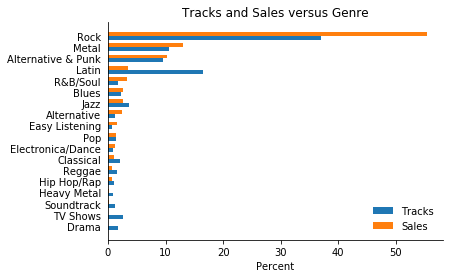

In [ ]:
q8 = '''

WITH genre_sales AS
    (
    SELECT
        g.name Genre,
        TOTAL(il.unit_price) Sales
    FROM invoice_line il
    LEFT JOIN track t ON t.track_id = il.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 1
    )

SELECT
    g.name Genre,
    COUNT(DISTINCT t.track_id) Tracks,
    100*CAST(COUNT(DISTINCT t.track_id) AS FLOAT) / CAST((SELECT COUNT(DISTINCT track_id) FROM track) AS FLOAT) Percent_tracks,
    gs.Sales,
    100*gs.Sales / (SELECT TOTAL(total) FROM invoice) Percent_sales
FROM genre g
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN genre_sales gs ON gs.Genre = g.name
GROUP BY 1
ORDER BY 4 ASC

'''

df2 = run_query(q8)

genre_tracks_sales = df2[['Genre', 'Percent_tracks', 'Percent_sales']].copy()

y = np.arange(len(genre_tracks_sales['Genre']))
width = 0.35

plt.barh(y - width/2, genre_tracks_sales['Percent_tracks'], width, label='Tracks')
plt.barh(y + width/2, genre_tracks_sales['Percent_sales'], width, label='Sales')

plt.xlabel('Percent')
plt.title('Tracks and Sales versus Genre')
plt.yticks(y, genre_tracks_sales['Genre'])
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(left=False)

plt.savefig('track_sales.jpg')
plt.show()


The range of tracks in the store mostly reflects the popularity of sales. I recommend adjusting the number of available tracks under `Latin`, `R&B/Soul`, `Blues`, and `Jazz`  genres to match the observed trends in sales.

## Media Type on Sales Popularity

In [ ]:
q9 = '''

SELECT
    Media_type,
    TOTAL(unit_price) Total_sales,
    ROUND(100*TOTAL(unit_price) / (SELECT TOTAL(unit_price) FROM invoice_line), 1) Percent_total_sales
FROM (
    SELECT
        il.invoice_line_id,
        il.invoice_id,
        il.track_id,
        il.unit_price,
        mt.name,
        CASE
            WHEN mt.name = (SELECT name FROM media_type WHERE name LIKE "%Protected%") THEN "Protected"
            ELSE "Non-protected"
            END
        AS Media_type
    FROM invoice_line il
    LEFT JOIN track t ON t.track_id = il.track_id
    INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
    )
GROUP BY 1

'''
run_query(q9)

,Media_type,Total_sales,Percent_total_sales
0,Non-protected,4274.82,90.8
1,Protected,434.61,9.2


Tracks under non-protected media types account for 90% of the total sales.

## Conclusion

I conclude the following from my analysis of the Chinook database:

* `Rock`,  `Alternative & Punk`, `Metal`, and `R&B/Soul` are among the top-selling music genres in the USA. The addition of new albums and tracks from American artists under these genres could improve the sales performance of the store.
* I determined the sales performance of the shop's employees. The sales performance of employees seems to depend on their hiring dates.
* Czech Republic, United Kingdom, and India show opportunities for growth due to high average values of sales (dollars per customer) and above-average order values (dollars per invoice).
* About 20% of total sales come from whole album purchases. The store should continue to selling individual tracks and whole albums.
* The artist `Iron Maiden` is mostly used in the playlists.
* About half of the available tracks in the store remain unpurchased.
* The range of tracks in the store mostly reflects the sales performance. I suggest revising the number of tracks classified under `Latin`, `R&B/Soul`, `Blues`, and `Jazz` genres following the observed trends in sales.
* Tracks categorized under non-protected media types significantly sell better than protected types.